# Author & Description

Author : Nikunj Goswami

Aim :  A model which corrects blur images and converts them to clear image.

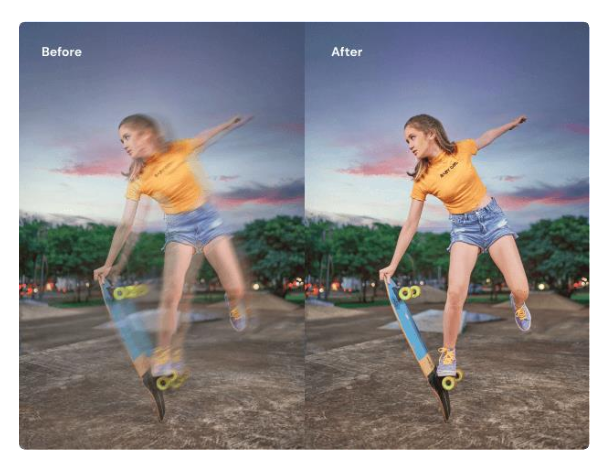

# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline
import random
import cv2
import os
import tensorflow as tf
from tqdm import tqdm

# Loading & Preprocessing Data

In [2]:
clear_img_data = 'data/sharp'
blur_img_data = 'data/defocused_blurred'

In [3]:
tf.keras.preprocessing.image.load_img??

Signature:
tf.keras.preprocessing.image.load_img(
    path,
    grayscale=False,
    color_mode='rgb',
    target_size=None,
    interpolation='nearest',
    keep_aspect_ratio=False,
)
Source:   
@keras_export("keras.utils.load_img", "keras.preprocessing.image.load_img")
def load_img(
    path,
    grayscale=False,
    color_mode="rgb",
    target_size=None,
    interpolation="nearest",
    keep_aspect_ratio=False,
):
    """Loads an image into PIL format.

    Usage:

    ```python
    image = tf.keras.utils.load_img(image_path)
    input_arr = tf.keras.utils.img_to_array(image)
    input_arr = np.array([input_arr])  # Convert single image to a batch.
    predictions = model.predict(input_arr)
    ```

    Args:
        path: Path to image file.
        grayscale: DEPRECATED use `color_mode="grayscale"`.
        color_mode: One of `"grayscale"`, `"rgb"`, `"rgba"`. Default: `"rgb"`.
          The desired image format.
        target_size: Either `None` (default to original size) or tup

In [4]:
clear_img = []
for file in tqdm(sorted(os.listdir(clear_img_data))):
    if any(extension in file for extension in ['.jpg', 'jpeg', '.png']):
        image = tf.keras.preprocessing.image.load_img(clear_img_data + '/' + file, target_size=(256,256))
        image = tf.keras.preprocessing.image.img_to_array(image).astype('float32') / 255
        clear_img.append(image)

clear_img = np.array(clear_img)

blur_img = []
for file in tqdm(sorted(os.listdir(blur_img_data))):
    if any(extension in file for extension in ['.jpg', 'jpeg', '.png']):
        image = tf.keras.preprocessing.image.load_img(blur_img_data + '/' + file, target_size=(256,256))
        image = tf.keras.preprocessing.image.img_to_array(image).astype('float32') / 255
        blur_img.append(image)

blur_img = np.array(blur_img)

100%|████████████████████████████████████████████████████████████████████████████████| 350/350 [00:04<00:00, 74.75it/s]


# Splitting Data

In [5]:
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.layers import Reshape, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras import backend as K


seed = 21
random.seed = seed
np.random.seed = seed

In [6]:
x = clear_img;
y = blur_img;
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [7]:
print(x_train[0].shape)
print(y_train[0].shape)

(256, 256, 3)
(256, 256, 3)


In [8]:
x_train[0][0]

array([[0.25490198, 0.22352941, 0.21176471],
       [0.29411766, 0.27450982, 0.25882354],
       [0.28627452, 0.26666668, 0.24313726],
       [0.29803923, 0.2784314 , 0.25490198],
       [0.31764707, 0.2901961 , 0.26666668],
       [0.3137255 , 0.28627452, 0.2627451 ],
       [0.32156864, 0.29411766, 0.25490198],
       [0.26666668, 0.24313726, 0.19607843],
       [0.24313726, 0.21960784, 0.17254902],
       [0.30588236, 0.28235295, 0.23529412],
       [0.29803923, 0.27450982, 0.22745098],
       [0.30980393, 0.28627452, 0.23921569],
       [0.32156864, 0.2901961 , 0.24705882],
       [0.31764707, 0.2784314 , 0.23921569],
       [0.3137255 , 0.27058825, 0.24705882],
       [0.30588236, 0.27058825, 0.2509804 ],
       [0.29411766, 0.26666668, 0.22745098],
       [0.29803923, 0.27058825, 0.24705882],
       [0.29411766, 0.26666668, 0.23529412],
       [0.28235295, 0.26666668, 0.22352941],
       [0.29803923, 0.25490198, 0.23921569],
       [0.29411766, 0.23921569, 0.23529412],
       [0.

264


Text(0.5, 0, 'Blur Image')

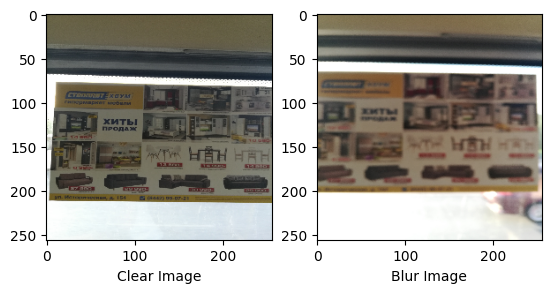

In [9]:
r = random.randint(0, len(clear_img)-1)
print(r)
fig = plt.figure()
fig.subplots_adjust(hspace=0.1, wspace=0.2)
ax = fig.add_subplot(1, 2, 1)
ax.imshow(clear_img[r])
ax.set_xlabel('Clear Image')
ax = fig.add_subplot(1, 2, 2)
ax.imshow(blur_img[r])
ax.set_xlabel('Blur Image')

# Defining Model


In [43]:
from tensorflow.keras import layers, models

# Encoder
encoder = models.Sequential([
    layers.Conv2D(filters=64, kernel_size=(3,3), strides=2, activation='relu', padding='same', input_shape=(256,256,3)),
    layers.Conv2D(filters=128, kernel_size=(3,3), strides=2, activation='relu', padding='same'),
    layers.Conv2D(filters=256, kernel_size=(3,3), strides=2, activation='relu', padding='same'),
    layers.Flatten(),
    layers.Dense(256, name='latent_vector')
], name='encoder')

encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 128, 128, 64)      1792      
                                                                 
 conv2d_10 (Conv2D)          (None, 64, 64, 128)       73856     
                                                                 
 conv2d_11 (Conv2D)          (None, 32, 32, 256)       295168    
                                                                 
 flatten_3 (Flatten)         (None, 262144)            0         
                                                                 
 latent_vector (Dense)       (None, 256)               67109120  
                                                                 
Total params: 67479936 (257.42 MB)
Trainable params: 67479936 (257.42 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [49]:
# Decoder
# Encoder output shape (from summary)
encoder_output_shape = (32, 32, 256)

# Decoder
decoder = models.Sequential([
    layers.Dense(units=encoder_output_shape[0] * encoder_output_shape[1] * encoder_output_shape[2], input_shape=(256,)),
    layers.Reshape(encoder_output_shape),
    layers.Conv2DTranspose(filters=256, kernel_size=(3,3), strides=2, activation='relu', padding='same'),
    layers.Conv2DTranspose(filters=128, kernel_size=(3,3), strides=2, activation='relu', padding='same'),
    layers.Conv2DTranspose(filters=64, kernel_size=(3,3), strides=2, activation='relu', padding='same'),
    layers.Conv2DTranspose(filters=3, kernel_size=(3,3), activation='sigmoid', padding='same', name='decoder_output')
], name='decoder')

decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 262144)            67371008  
                                                                 
 reshape_4 (Reshape)         (None, 32, 32, 256)       0         
                                                                 
 conv2d_transpose_12 (Conv2  (None, 64, 64, 256)       590080    
 DTranspose)                                                     
                                                                 
 conv2d_transpose_13 (Conv2  (None, 128, 128, 128)     295040    
 DTranspose)                                                     
                                                                 
 conv2d_transpose_14 (Conv2  (None, 256, 256, 64)      73792     
 DTranspose)                                                     
                                                           

In [50]:
# Autoencoder
autoencoder = models.Sequential([
    encoder,
    decoder
], name='autoencoder')

autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Sequential)        (None, 256)               67479936  
                                                                 
 decoder (Sequential)        (None, 256, 256, 3)       68331651  
                                                                 
Total params: 135811587 (518.08 MB)
Trainable params: 135811587 (518.08 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [51]:
autoencoder.compile(loss='mse', optimizer='adam',metrics=["accuracy"])

In [52]:
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               verbose=1,
                               min_lr=0.5e-6)

In [53]:
callbacks = [lr_reducer]
history = autoencoder.fit(blur_img,
                      clear_img,
                      validation_data=(blur_img, clear_img),
                      epochs=100,
                      batch_size=32,
                      callbacks=callbacks)

Epoch 1/100


9/9 [==============================] - 28s 3s/step - loss: 0.0698 - accuracy: 0.5140 - val_loss: 0.0688 - val_accuracy: 0.6289 - lr: 0.0010
Epoch 2/100
9/9 [==============================] - 27s 3s/step - loss: 0.0679 - accuracy: 0.6459 - val_loss: 0.0664 - val_accuracy: 0.6685 - lr: 0.0010
Epoch 3/100
9/9 [==============================] - 29s 3s/step - loss: 0.0667 - accuracy: 0.6685 - val_loss: 0.0654 - val_accuracy: 0.6662 - lr: 0.0010
Epoch 4/100
9/9 [==============================] - 29s 3s/step - loss: 0.0643 - accuracy: 0.6461 - val_loss: 0.0617 - val_accuracy: 0.6509 - lr: 0.0010
Epoch 5/100
9/9 [==============================] - 30s 3s/step - loss: 0.0610 - accuracy: 0.6598 - val_loss: 0.0542 - val_accuracy: 0.6679 - lr: 0.0010
Epoch 6/100
9/9 [==============================] - 29s 3s/step - loss: 0.0528 - accuracy: 0.6669 - val_loss: 0.0537 - val_accuracy: 0.6650 - lr: 0.0010
Epoch 7/100
9/9 [==============================] - 29s 3s/step - loss: 0.0494 - accura

# Prediction

1/1 [==============================] - 0s 51ms/step


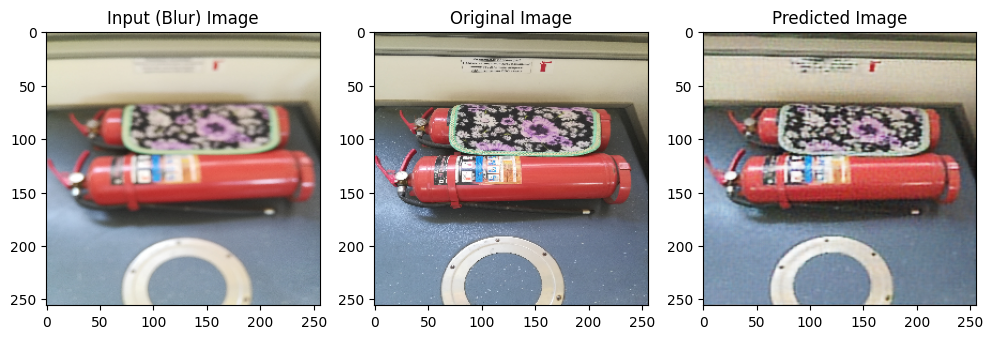

In [58]:
# Load the images
sample_blur_path = 'sample/blur_sample_04.jpg'
sample_clear_path = 'sample/clear_sample_04.jpg'

# Preprocess the images
def preprocess_image(image_path):
    image = tf.keras.preprocessing.image.load_img(image_path, target_size=(256, 256))
    image = tf.keras.preprocessing.image.img_to_array(image).astype('float32') / 255
    return image

sample_blur = preprocess_image(sample_blur_path)
sample_clear = preprocess_image(sample_clear_path)

# Make predictions
sample_blur_input = np.expand_dims(sample_blur, axis=0)  # Add batch dimension
predicted_image = autoencoder.predict(sample_blur_input)
predicted_image = np.squeeze(predicted_image)  # Remove batch dimension

# Visualize the images
fig = plt.figure(figsize=(12, 10))
fig.subplots_adjust(hspace=0.1, wspace=0.2)

# Input (Blur) image
ax = fig.add_subplot(1, 3, 1)
ax.imshow(sample_blur)
ax.set_title('Input (Blur) Image')

# Original(Clear) Image
ax = fig.add_subplot(1, 3, 2)
ax.imshow(sample_clear)
ax.set_title('Original Image')

# Predicted image
ax = fig.add_subplot(1, 3, 3)
ax.imshow(predicted_image)
ax.set_title('Predicted Image')

plt.show()

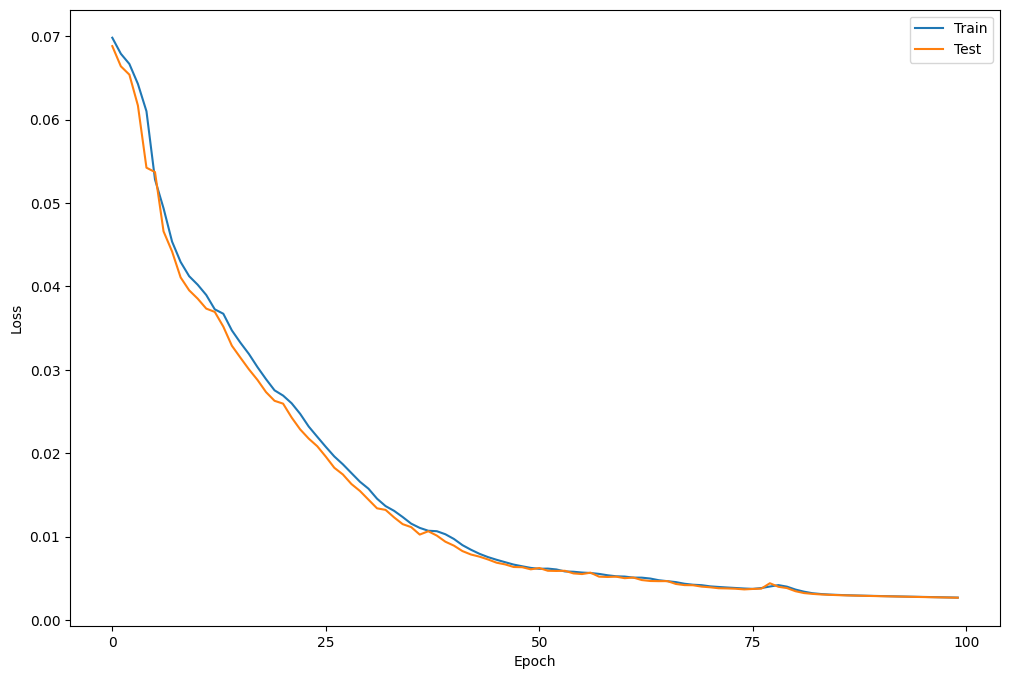

In [59]:
plt.figure(figsize=(12,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Train', 'Test'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(np.arange(0, 101, 25))
plt.show()

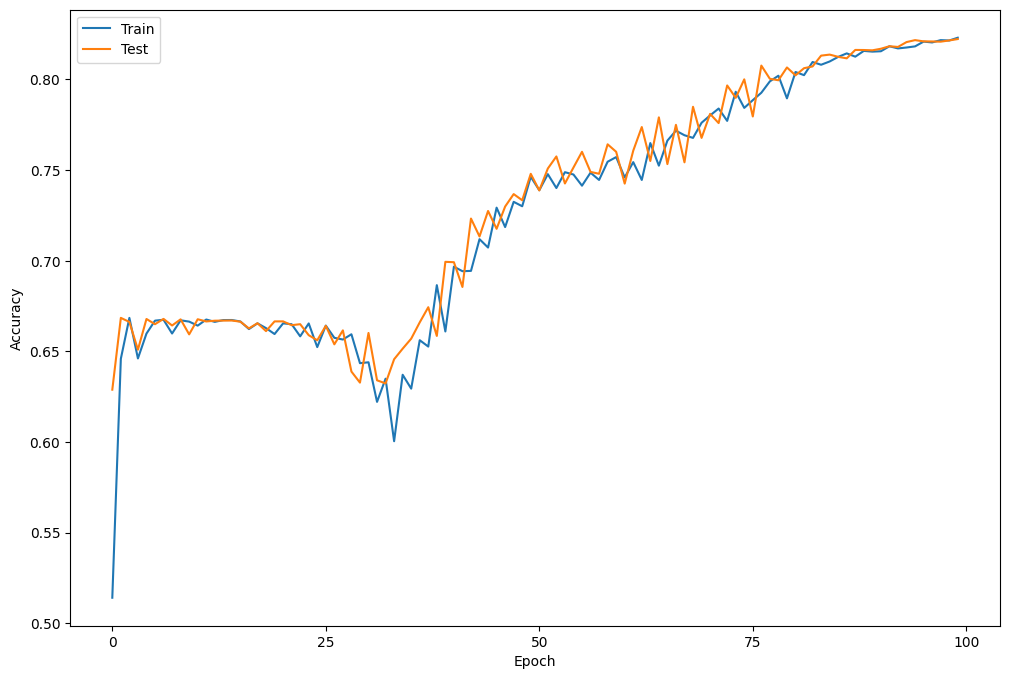

In [60]:
plt.figure(figsize=(12,8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Train', 'Test'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(np.arange(0, 101, 25))
plt.show()

# Saving Model

In [61]:
import pickle

model_file_path = 'model.pkl'

with open(model_file_path, 'wb') as file:
    pickle.dump(autoencoder, file)

print(f"\nModel saved to {model_file_path}")


Model saved to model.pkl
